# Fake News Detector - Evaluate Model
The notebook covers the evaluation of model with metrics run on ISOT Fake News detection dataset, provided by Kaggle.

The Kaggle Link : https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [5]:
# Step 1: Install required packages
!pip install kagglehub[hf-datasets] pandas --quiet
!python -m nltk.downloader punkt_tab wordnet stopwords > /dev/null

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Step 2: Import libraries
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from time import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import joblib
from kagglehub import KaggleDatasetAdapter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import kagglehub
from pathlib import Path

## Load dataset from the Kaggle

In [7]:
# Load datasets directly from Kaggle
def load_dataset():
    print("⏳ Loading datasets from Kaggle...")
    fake_ds = kagglehub.load_dataset(
        KaggleDatasetAdapter.HUGGING_FACE,
        "clmentbisaillon/fake-and-real-news-dataset",
        "Fake.csv",
        hf_kwargs={"split": "all"}
    )

    true_ds = kagglehub.load_dataset(
        KaggleDatasetAdapter.HUGGING_FACE,
        "clmentbisaillon/fake-and-real-news-dataset",
        "True.csv",
        hf_kwargs={"split": "all"}
    )

    # Convert to pandas DataFrames
    fake_df = fake_ds.to_pandas()
    fake_df['label'] = 1  # Fake news

    true_df = true_ds.to_pandas()
    true_df['label'] = 0  # Real news

    # Combine datasets
    df = pd.concat([fake_df, true_df], ignore_index=True)

    print(f"✅ Dataset loaded: {len(df)} records")
    print(f"   - Fake news: {len(fake_df)} samples")
    print(f"   - Real news: {len(true_df)} samples")

    return df

# Load the data
full_df = load_dataset()

⏳ Loading datasets from Kaggle...


<ipython-input-7-492e9c0ad2ae>:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  fake_ds = kagglehub.load_dataset(
<ipython-input-7-492e9c0ad2ae>:11: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  true_ds = kagglehub.load_dataset(


✅ Dataset loaded: 44898 records
   - Fake news: 23481 samples
   - Real news: 21417 samples


## Data processing

In [11]:
# Define project structure paths
PROJECT_ROOT = Path.cwd()
DATA_RAW = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

In [15]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Remove special characters/numbers except basic punctuation
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Remove short words (length < 2)
    tokens = [word for word in tokens if len(word) > 1]

    return ' '.join(tokens)

In [16]:
# Full preprocessing workflow
def preprocess_data(df):
    print("\n🧹 Preprocessing data...")
    start = time()

    # Save raw data
    raw_path = DATA_RAW / "raw_combined.csv"
    df.to_csv(raw_path, index=False)
    print(f"✅ Raw data saved to: {raw_path}")

    # Clean data
    df = df.drop_duplicates(subset=['title', 'text'])
    df['text'] = df['text'].fillna('')
    df['title'] = df['title'].fillna('')

    # Combine title and text
    df['full_text'] = df['title'] + ' ' + df['text']

    # Preprocess text in batches
    batch_size = 2000
    batches = [df.iloc[i:i+batch_size] for i in range(0, len(df), batch_size)]

    processed_texts = []
    for i, batch in enumerate(batches):
        print(f"  Processing batch {i+1}/{len(batches)}")
        processed_batch = batch['full_text'].apply(preprocess_text)
        processed_texts.extend(processed_batch)

    df['processed_text'] = processed_texts

    # Create train-test split
    train_df = df.sample(frac=0.8, random_state=42)
    test_df = df.drop(train_df.index)

    # Save processed data
    train_path = DATA_PROCESSED / "train_processed.csv"
    test_path = DATA_PROCESSED / "test_processed.csv"

    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)

    print(f"✅ Preprocessing completed in {time()-start:.2f} seconds")
    print(f"   - Train set ({len(train_df)} samples): {train_path}")
    print(f"   - Test set ({len(test_df)} samples): {test_path}")

    # Save additional artifacts for future reference
    sample_path = DATA_PROCESSED / "sample_processed_texts.csv"
    train_df[['processed_text', 'label']].head(100).to_csv(sample_path, index=False)
    print(f"   - Sample processed texts: {sample_path}")

    return train_df, test_df

# Preprocess the data
train_df, test_df = preprocess_data(full_df)

X_train = train_df['processed_text']
y_train = train_df['label']
X_test = test_df['processed_text']
y_test = test_df['label']


🧹 Preprocessing data...
✅ Raw data saved to: /content/data/raw/raw_combined.csv


<ipython-input-16-641032f2526c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].fillna('')
<ipython-input-16-641032f2526c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'] = df['title'].fillna('')
<ipython-input-16-641032f2526c>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

  Processing batch 1/20
  Processing batch 2/20
  Processing batch 3/20
  Processing batch 4/20
  Processing batch 5/20
  Processing batch 6/20
  Processing batch 7/20
  Processing batch 8/20
  Processing batch 9/20
  Processing batch 10/20
  Processing batch 11/20
  Processing batch 12/20
  Processing batch 13/20
  Processing batch 14/20
  Processing batch 15/20
  Processing batch 16/20
  Processing batch 17/20
  Processing batch 18/20
  Processing batch 19/20
  Processing batch 20/20


<ipython-input-16-641032f2526c>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_text'] = processed_texts


✅ Preprocessing completed in 193.13 seconds
   - Train set (31284 samples): /content/data/processed/train_processed.csv
   - Test set (7821 samples): /content/data/processed/test_processed.csv
   - Sample processed texts: /content/data/processed/sample_processed_texts.csv


## Load the model

In [17]:
model_path = "/content/fake_news_model.pkl"

try:
    model = joblib.load(model_path)
    print(f"Model loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")
    model = None

Model loaded successfully from /content/fake_news_model.pkl


## Evaluating the model


📊 Evaluating model...
✅ Evaluation completed in 2.79 seconds

Classification Report:
              precision    recall  f1-score   support

        Real       0.98      0.99      0.99      4202
        Fake       0.99      0.98      0.98      3619

    accuracy                           0.99      7821
   macro avg       0.99      0.99      0.99      7821
weighted avg       0.99      0.99      0.99      7821



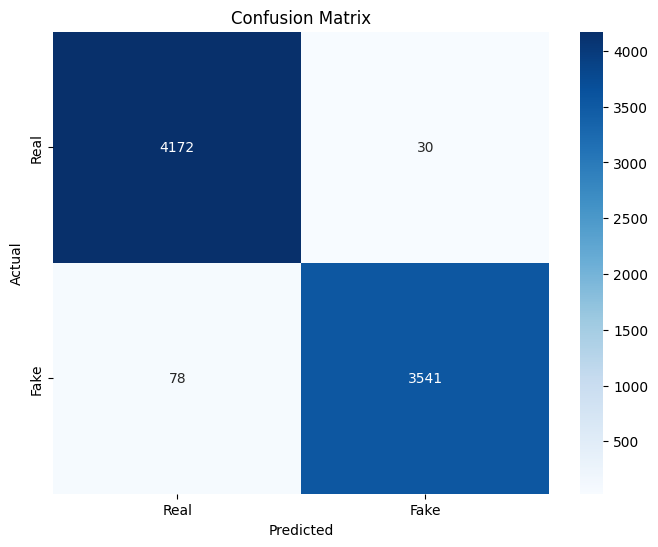

In [18]:
# Evaluate the model
def evaluate_model(model, X_test, y_test):
    print("\n📊 Evaluating model...")
    start = time()

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    test_time = time() - start

    print(f"✅ Evaluation completed in {test_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'test_time': test_time
    }

# Evaluate
metrics = evaluate_model(model, X_test, y_test)